In [ ]:
# Check if GPU is available
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)
'''

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import glob
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
import shutil

### GAN Kaggle Competition

#### Problem Description
Build and train a GAN on the included Monet dataset to generate images in the style of Monet.  The zip file submission containing 7000 to 10000 Monet-like jpegs will be evaluated on MiFID (Memorization-informed Fréchet Inception Distance) metric.

#### Data Description
There are four directories in the dataset for this project.  Two monet directories containing the same 300 photos just in different data formats, namely TFRecord and jpeg.  Similarly, the two photo directories contain a variety of 7028 generic photos.  All photos, regardless of format are **RGB** of size **256 x 256**.  Those photos in the monet directory are to be used to train the model, and the photos directory can be used to add monet-style to generate fake Monets...Monauxs :)  See examples of each directory in the EDA section of the Notebook.

#### Exploratory Data Analysis

First, examples from each directory will be displayed.

In [ ]:
monet_paths = glob.glob("../input/gan-getting-started/monet_jpg/*.jpg")

print(f'Total number of Monet images: {len(monet_paths)}')

fig, axes = plt.subplots(4, 5, figsize=(12, 6))

for ax, img_path in zip(axes.flatten(), monet_paths[:20]):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    
fig.suptitle("Monet Directory Examples")
plt.tight_layout()
plt.show()

In [ ]:
photo_paths = glob.glob("../input/gan-getting-started/photo_jpg/*.jpg")

print(f'Total number of Generic Photo images: {len(photo_paths)}')

fig, axes = plt.subplots(4, 5, figsize=(12, 6))

for ax, img_path in zip(axes.flatten(), photo_paths[:20]):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    
fig.suptitle("Generic Photo Directory Examples")
plt.tight_layout()
plt.show()

The Monet images show obvious brush strokes, but the types of images seem similar.  Mostly landscapes with the occasional object or person. 

#### Analysis
In reading the optional reading for the week, I came across a very similar task as Monaux.  Jonathon Hui did a great job of breaking down the exercise using CycleGAN:

>The concept of applying GAN to an existing design is very simple. We can treat the original problem as a simple image reconstruction. We use a deep network G to convert image x to y. We reverse the process with another deep network F to reconstruct the image. Then, we use a mean square error MSE to guide the training of G and F.
>
>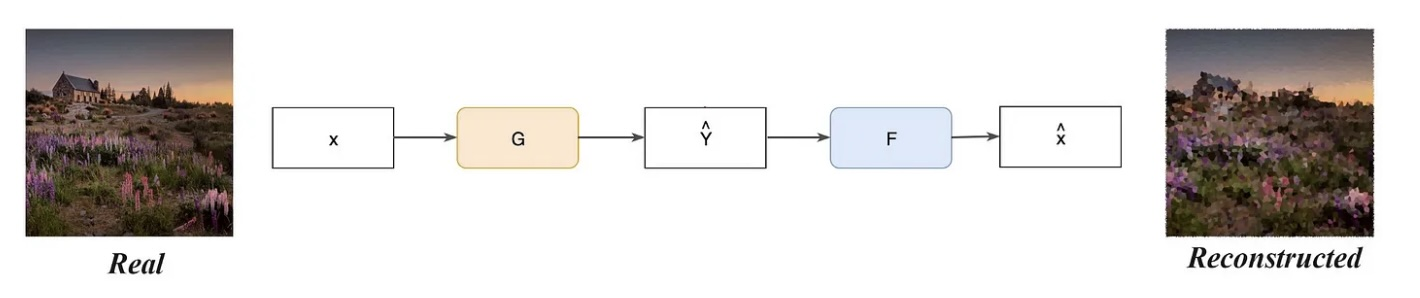
>
>However, we are not interested in reconstructing images. We want to create y resembling certain styles. In GAN, a discriminator D is added to an existing design to guide the generator network to perform better. D acts as a critic between the training samples and the generated images. Through this criticism, we use backpropagation to modify the generator to produce images that address the shortcoming identified by the discriminator. In this problem, we introduce a discriminator D to make sure Y resemble Van Gogh paintings.
>
>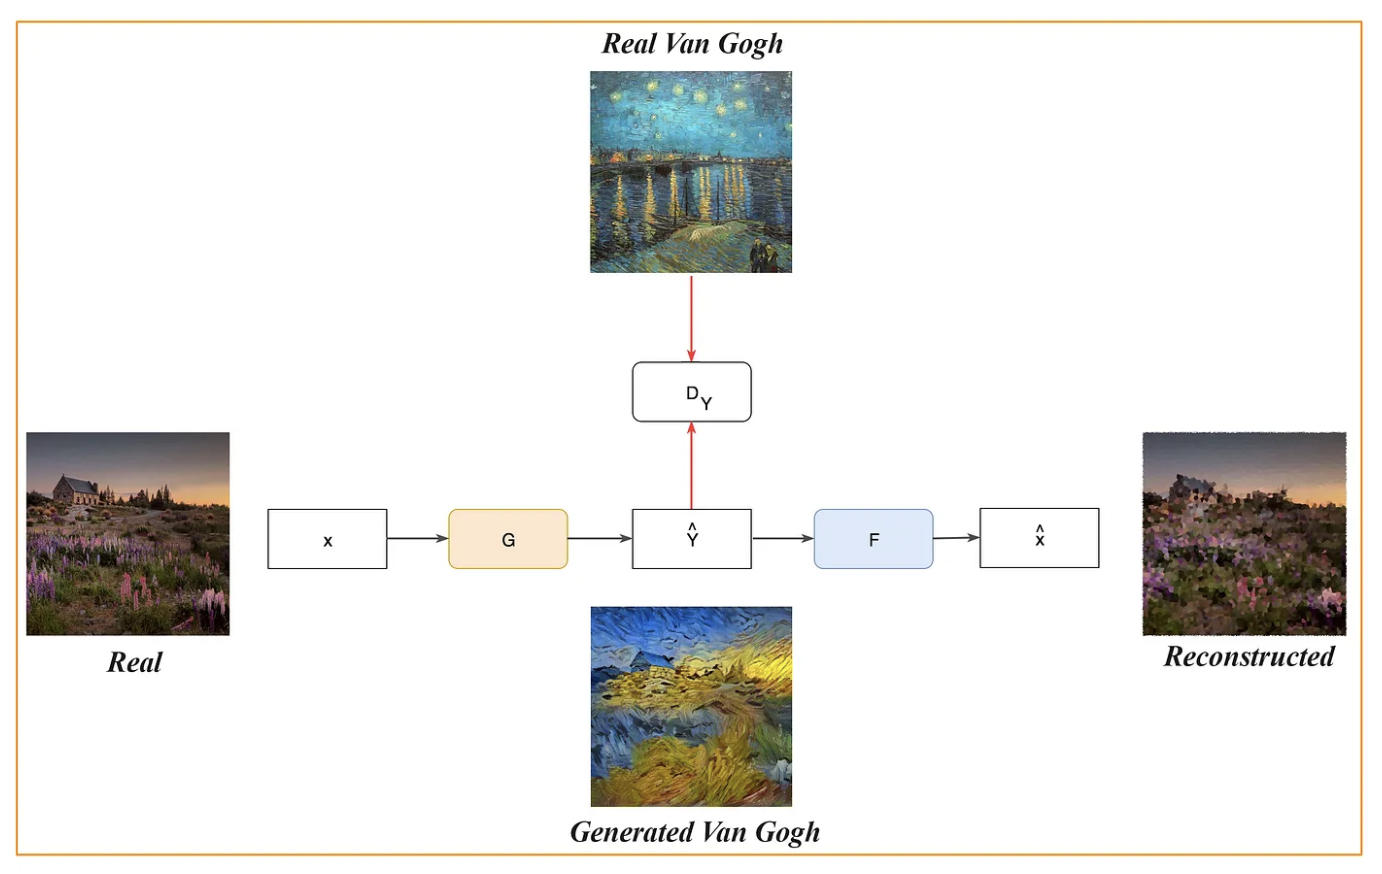
>
https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7
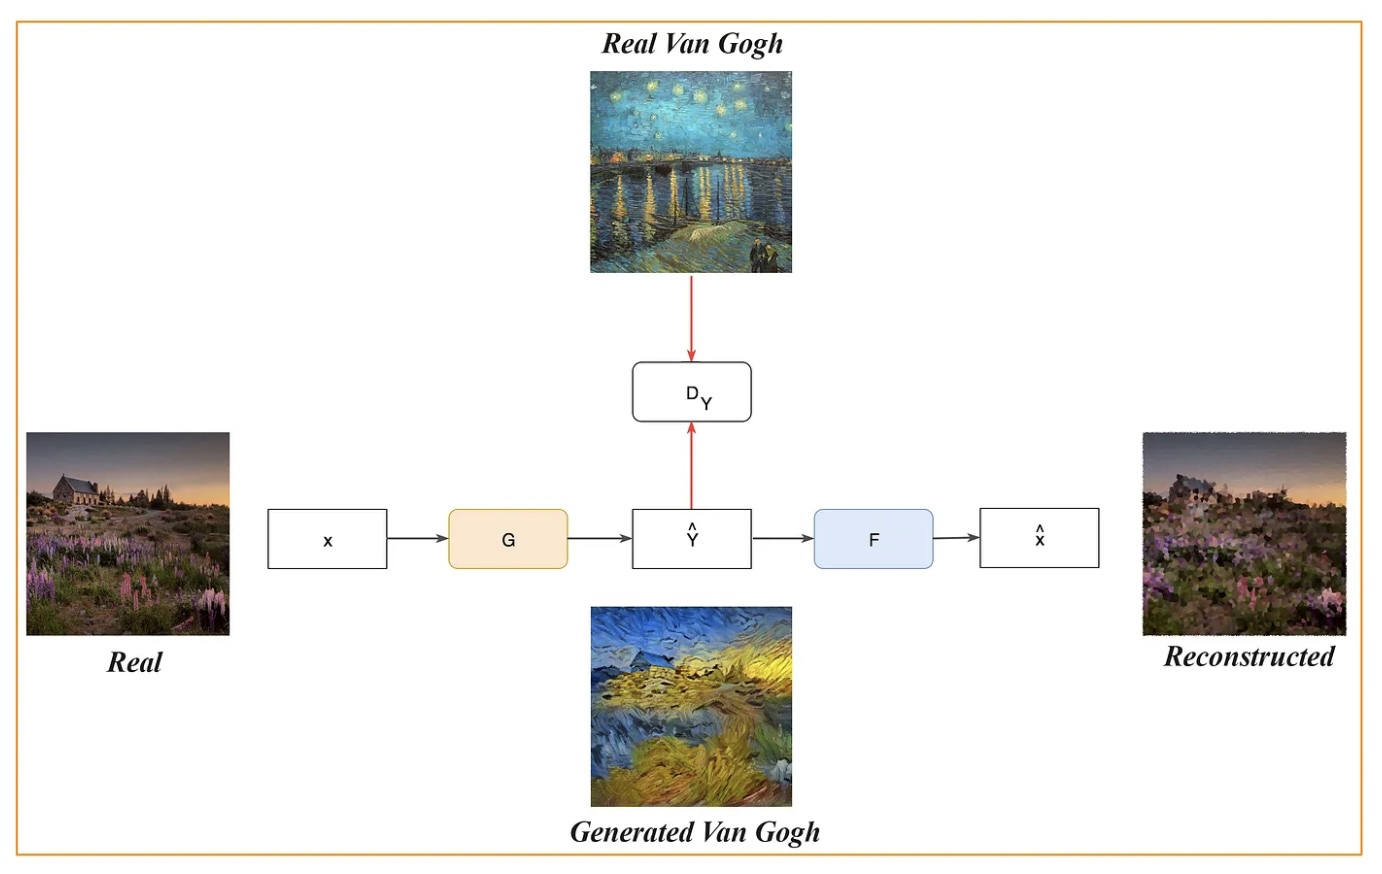
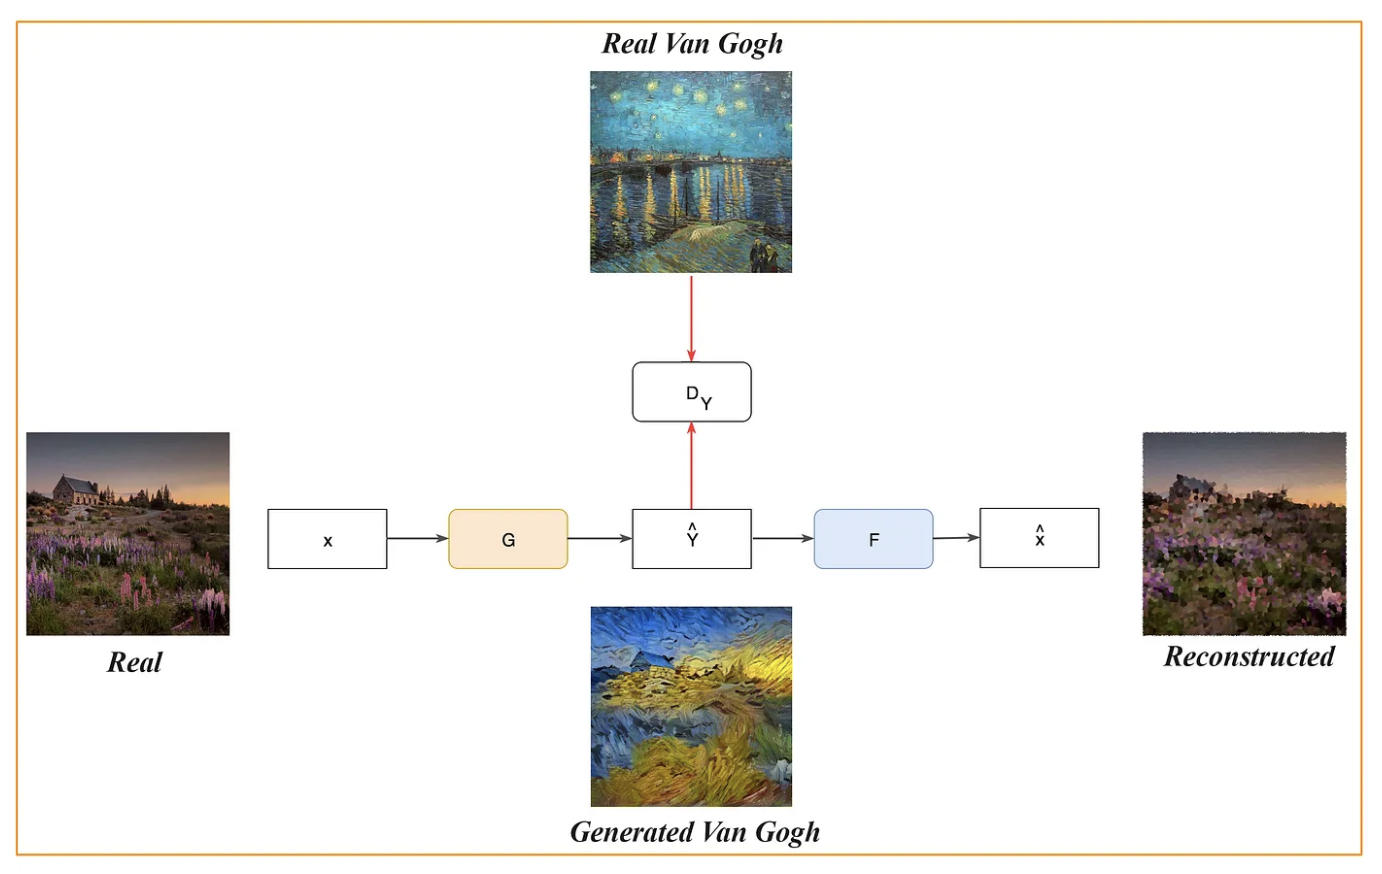

In [ ]:
#loads and processes images from directories
def load_kaggle_dataset(monet_dir, photo_dir):
    monet_images = []
    photo_images = []
    #Read image files from the given directories
    for file in sorted(os.listdir(monet_dir)):
        img = tf.io.read_file(os.path.join(monet_dir, file))
        img = tf.image.decode_jpeg(img, channels=3) #Decodes JPEG images into tensors
        img = tf.image.resize(img, [256, 256])  # Updated to 256x256 for CycleGAN
        img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
        monet_images.append(img)
    
    for file in sorted(os.listdir(photo_dir)):
        img = tf.io.read_file(os.path.join(photo_dir, file))
        img = tf.image.decode_jpeg(img, channels=3) #Decodes JPEG images into tensors
        img = tf.image.resize(img, [256, 256])  # Updated to 256x256 for CycleGAN
        img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
        photo_images.append(img)
        
    #Convert the processed images into TensorFlow datasets
    monet_ds = tf.data.Dataset.from_tensor_slices(monet_images).prefetch(buffer_size=tf.data.AUTOTUNE)
    photo_ds = tf.data.Dataset.from_tensor_slices(photo_images).prefetch(buffer_size=tf.data.AUTOTUNE)

    #Shuffle and batche the datasets with a batch size of 1, using prefetch to optimize performance.
    monet_ds = monet_ds.shuffle(len(monet_images)).batch(1).prefetch(buffer_size=tf.data.AUTOTUNE)
    photo_ds = photo_ds.shuffle(len(photo_images)).batch(1).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Return datasets ready for training GAN model
    return monet_ds, photo_ds

monet_path = "/kaggle/input/gan-getting-started/monet_jpg/"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg/"

monet_ds, photo_ds = load_kaggle_dataset(monet_path, photo_path)



CycleGAN transfers pictures from one domain (photo dataset) to another (Monet dataset). The implementation will include:

Generator: Uses a U-Net-inspired ResNet architecture.
Discriminator: A PatchGAN-based classifier.
CycleGAN Losses: Adversarial loss, cycle consistency loss, and identity loss.

In [ ]:
# standard resnet architecture, used group normalization because beneficial for small batch sizes
def resnet_block(filters, size=3, stride=1, groups=32):
    def block(x):
        x_init = x
        x = layers.Conv2D(filters, size, strides=stride, padding="same", use_bias=False)(x)
        x = layers.GroupNormalization(groups=groups)(x) 
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, size, strides=stride, padding="same", use_bias=False)(x)
        x = layers.GroupNormalization(groups=groups)(x)  
        x = layers.Add()([x, x_init])  # Residual connection
        return x
    return block

    #Reflection padding helps preserve edge information by mirroring pixel values
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        p_h, p_w = self.padding
        return tf.pad(input_tensor, [[0, 0], [p_h, p_h], [p_w, p_w], [0, 0]], "REFLECT")

#designed for image translation, takes an input image and transforms it into a new version 
def build_generator():
    input_layer = layers.Input(shape=(256, 256, 3))
    
    x = ReflectionPadding2D((3, 3))(input_layer)  
    x = layers.Conv2D(64, (7, 7), padding="valid", use_bias=False)(x)  
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (3, 3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    for _ in range(6):
        x = resnet_block(256)(x)

    # Upsampling
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output Layer
    x = layers.Conv2D(3, (7, 7), padding="same", activation="tanh")(x)

    return keras.Model(input_layer, x)


In [ ]:
#used for adversarial training, helps improve generator by distinguishing between real and generated images
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    #Conv layers for feature extraction
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    #1-channel output (no activation) that represents whether each patch of the image is real or fake
    outputs = tf.keras.layers.Conv2D(1, 4, padding='same')(x)  
    
    return tf.keras.Model(inputs, outputs, name="Discriminator")

In [ ]:
# Loss functions, raw values (not probs)
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

#Encourages the generator to fool the discriminator
def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)
    
#Measures how well the discriminator distinguishes real vs. fake images
def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

#Ensures that after transformation (e.g., photo → Monet → photo), the cycled image is close to the original
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

In [ ]:
class CycleGAN:
    def __init__(self, learning_rate=0.0002, beta_1=0.5):
        # Initialize models
        self.models = {
            "generator_G": build_generator(),  # Generator: Converts Real photo → Monet-style
            "generator_F": build_generator(),  # Generator: Converts Monet-style → Real photo
            "discriminator_X": build_discriminator(),  # Discriminator: Checks if photo is real
            "discriminator_Y": build_discriminator()  # Discriminator: Checks if Monet painting is real
        }
        
        # Initialize optimizers
        self.optimizers = {
            "gen_G": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Generator_G
            "gen_F": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Generator_F
            "disc_X": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Discriminator_X
            "disc_Y": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1) # Optimizer for Discriminator_Y
        }

    # Train one batch
    def train_step(self, real_X, real_Y):
        with tf.GradientTape(persistent=True) as tape:
            #Generate Fake and Cycled Images
            fake_Y = self.models["generator_G"](real_X, training=True)
            cycled_X = self.models["generator_F"](fake_Y, training=True)
            
            fake_X = self.models["generator_F"](real_Y, training=True)
            cycled_Y = self.models["generator_G"](fake_X, training=True)
            
            # Compute Discriminator Outputs
            real_output_X = self.models["discriminator_X"](real_X, training=True)
            fake_output_X = self.models["discriminator_X"](fake_X, training=True)
            
            real_output_Y = self.models["discriminator_Y"](real_Y, training=True)
            fake_output_Y = self.models["discriminator_Y"](fake_Y, training=True)
            
            # Compute Losses
            gen_G_loss = generator_loss(fake_output_Y) + cycle_loss(real_X, cycled_X)
            gen_F_loss = generator_loss(fake_output_X) + cycle_loss(real_Y, cycled_Y)
            
            disc_X_loss = discriminator_loss(real_output_X, fake_output_X)
            disc_Y_loss = discriminator_loss(real_output_Y, fake_output_Y)
            
        # Computed gradients of losses w.r.t. model parameters
        gradients = {
            "gen_G": tape.gradient(gen_G_loss, self.models["generator_G"].trainable_variables),
            "gen_F": tape.gradient(gen_F_loss, self.models["generator_F"].trainable_variables),
            "disc_X": tape.gradient(disc_X_loss, self.models["discriminator_X"].trainable_variables),
            "disc_Y": tape.gradient(disc_Y_loss, self.models["discriminator_Y"].trainable_variables)
        }

        # Applies gradient updates using the respective Adam optimizer        
        for key, grads in gradients.items():
            valid_grads = [(grad, var) for grad, var in zip(grads, self.models[key.replace("gen_", "generator_").replace("disc_", "discriminator_")].trainable_variables) if grad is not None]
            self.optimizers[key].apply_gradients(valid_grads)
            
        return gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss

    # Trains CycleGAN model over multiple epochs
    def train(self, dataset_X, dataset_Y, epochs):
        for epoch in range(epochs):
            for real_X, real_Y in zip(dataset_X, dataset_Y):
                gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss = self.train_step(real_X, real_Y)
            print(f"Epoch {epoch+1}, Gen G Loss: {gen_G_loss.numpy()}, Gen F Loss: {gen_F_loss.numpy()}, Disc X Loss: {disc_X_loss.numpy()}, Disc Y Loss: {disc_Y_loss.numpy()}")

In [ ]:
# Start Training with appropriate parameters
cycle_gan = CycleGAN(learning_rate=0.0002, beta_1=0.5)
cycle_gan.train(photo_ds, monet_ds, epochs=10)

In [ ]:
! mkdir ../images

# Saving for submission

i = 1
for img in photo_ds:
    prediction = cycle_gan.models["generator_G"](img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


### Result
My CycleGAN model scored 224.32421.  The discriminator seems to have overfit.  If I had more computing power I would run it again and stop earlier.  I also read that the smaller domain (Monets) could be bootstrapped and that could help performance. Overall, I was just glad I was able to get the kaggle notebook to run to completion.  It was my first experience using kaggle notebooks, and it was frustrating how often it crashed or froze or appeared to be running but wasn't!

https://www.mdpi.com/2076-3417/12/7/3411#:~:text=Discriminator%20overfitting%20could%20occur%20during,lead%20to%20an%20underperforming%20GAN.

### Discussion/Conclusion
This was my first experience with GANs and with Kaggle Notebooks.  I was a little discouraged/frustrated when in one of the optional readings it stated that autoencoders "are rarely used in practical applications." This frustration magnified when I couldn't get my code to compile!  Perseverance is key.  And after lots of searching and reading and searching and reading and then waiting hours for the model to train, I was able to complete the project!  I struggled with the CNN models in Week 3 and similarly with the generator part of this model.  When I finally got it working, I made the generator too deep so I didn't have enough computing power to train the model.  I adjusted the model to a more reasonable size and tried again.  

### 